In [25]:
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym
import qwop_gym

# Reload train_ppo module to pick up latest changes
import importlib
import train_ppo
importlib.reload(train_ppo)

# Import custom PPO components from train_ppo.py
from train_ppo import (
    ActorCritic,
    RolloutBuffer,
    create_qwop_env,
    train_ppo,
    evaluate_policy,
    save_checkpoint,
    load_checkpoint
)

print("All modules imported successfully!")

BROWSER_PATH = "C:\\Program Files\\BraveSoftware\\Brave-Browser\\Application\\brave.exe"
DRIVER_PATH = "C:\\Program Files\\chromedriver-win64\\chromedriver-win64\\chromedriver.exe"


All modules imported successfully!


# Exploring Action Space

In [26]:
# Action space mapping (for 16 actions - full action set)
action_map = {
    0: "none",
    1: "Q",
    2: "W", 
    3: "O",
    4: "P",
    5: "Q+W",
    6: "Q+O",
    7: "Q+P",
    8: "W+O",
    9: "W+P",
    10: "O+P",
    11: "Q+W+O",
    12: "Q+W+P",
    13: "Q+O+P",
    14: "W+O+P",
    15: "Q+W+O+P"
}

In [27]:
# Setup QWOP environment and test random actions
env = create_qwop_env(BROWSER_PATH, DRIVER_PATH)

print("Environment created successfully!")
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)
print("\nStarting random key presses...\n")

# Reset environment
obs, info = env.reset()
print(f"Initial torso y-level: {obs[1]:.4f}")  # obs[1] is torso_y

# Press random keys and print torso y-level
num_steps = 20
for step in range(num_steps):
    # Sample random action (random key combination)
    action = env.action_space.sample()

    keys_pressed = action_map.get(action, 'None')

    # Take action in environment
    obs, reward, terminated, truncated, info = env.step(action)
    
    print(f"Step {step+1:2d} | Keys: {keys_pressed:7s} | Reward: {reward:6.3f}")
    
    if terminated or truncated:
        print(f"\nEpisode ended at step {step+1}")
        print(f"Terminated: {terminated}, Truncated: {truncated}")
        break

print("\nRandom key test completed!")
env.close()

Environment created successfully!
Action space: Discrete(16)
Observation space: Box(-1.0, 1.0, (60,), float32)

Starting random key presses...

Initial torso y-level: -0.1823
Step  1 | Keys: Q+O     | Reward:  0.086
Step  2 | Keys: Q+W+P   | Reward: -0.030
Step  3 | Keys: Q+W+O+P | Reward: -0.029
Step  4 | Keys: O+P     | Reward: -0.024
Step  5 | Keys: P       | Reward: -0.019
Step  6 | Keys: Q+W     | Reward: -0.016
Step  7 | Keys: Q+P     | Reward: -0.017
Step  8 | Keys: Q+W+P   | Reward: -0.024
Step  9 | Keys: Q       | Reward: -0.023
Step 10 | Keys: none    | Reward: -0.022
Step 11 | Keys: Q+P     | Reward: -0.020
Step 12 | Keys: Q+W+P   | Reward: -0.025
Step 13 | Keys: W+O     | Reward: -0.053
Step 14 | Keys: Q+O     | Reward: -0.061
Step 15 | Keys: Q+W+O   | Reward: -0.066
Step 16 | Keys: Q+O+P   | Reward: -0.065
Step 17 | Keys: Q+W     | Reward: -0.051
Step 18 | Keys: W+P     | Reward: -0.061
Step 19 | Keys: Q+W+O+P | Reward: -0.056
Step 20 | Keys: Q+W     | Reward: -0.050

Rand

# Understanding the Observation Space
Dissecting what information the environment provides us.

In [28]:
# Explore observation space structure
env = create_qwop_env(BROWSER_PATH, DRIVER_PATH)
obs, info = env.reset()

print("=" * 35)
print("OBSERVATION SPACE ANALYSIS")
print("=" * 35)
print(f"Observation Shape: {obs.shape}")
print(f"Observation Space: {env.observation_space}")
print(f"Initial Info Dict: {info}")

# Display observations
print(f"\nObservation values:")
for i in range(len(obs)//5):
    for j in range(5):
        print(f"  obs[{i*5+j:2d}] = {obs[i*5+j]:8.4f}", end=' | ')
    print()

print(f"\nTotal observation dimensions: {len(obs)}")

env.close()

OBSERVATION SPACE ANALYSIS
Observation Shape: (60,)
Observation Space: Box(-1.0, 1.0, (60,), float32)
Initial Info Dict: {'time': np.float32(0.0054033333), 'distance': np.float32(0.25110978), 'avgspeed': np.float32(46.473125), 'is_success': False}

Observation values:
  obs[ 0] =  -0.9764 |   obs[ 1] =  -0.1823 |   obs[ 2] =  -0.2086 |   obs[ 3] =  -0.5000 |   obs[ 4] =  -0.3929 | 
  obs[ 5] =  -0.9738 |   obs[ 6] =  -0.5574 |   obs[ 7] =   0.0107 |   obs[ 8] =  -0.5002 |   obs[ 9] =  -0.3930 | 
  obs[10] =  -0.9728 |   obs[11] =  -0.2759 |   obs[12] =   0.1507 |   obs[13] =  -0.5000 |   obs[14] =  -0.3929 | 
  obs[15] =  -0.9752 |   obs[16] =   0.5574 |   obs[17] =  -0.2650 |   obs[18] =  -0.5000 |   obs[19] =  -0.3929 | 
  obs[20] =  -0.9737 |   obs[21] =   0.8137 |   obs[22] =   0.0200 |   obs[23] =  -0.5000 |   obs[24] =  -0.3929 | 
  obs[25] =  -0.9701 |   obs[26] =  -0.2825 |   obs[27] =  -0.2008 |   obs[28] =  -0.5000 |   obs[29] =  -0.3929 | 
  obs[30] =  -0.9763 |   obs[31] = 

This corresponds to the following observation table.

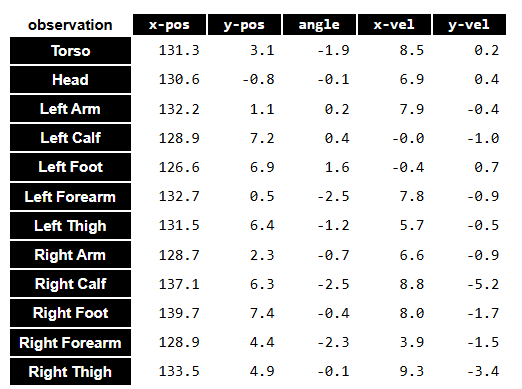

# Understanding Reward System

We attempted to understand the reward system implemented in the qwop wrapper for gymanasium. We looked at the _calc_reward function from the github code. (Link: https://github.com/smanolloff/qwop-gym/blob/main/qwop_gym/envs/v1/qwop_env.py). It was as follows:

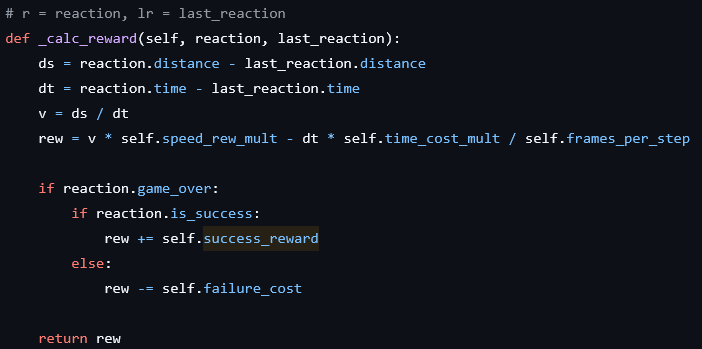

As shown the reward system is straightforward. To get more reward, the model tries to increase velocity (v) and decrease the steps required to reach the goal! It avoids falling (failure) to not incurr the heavy failure penalty.

We find it impressive that RL models can train well on it. However we also notice the drawback of the straightforward reward system as it promotes the model to use the stable but slow "knee-scraping" strategy (explained later) for completing the game. 